In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set up paths
BASE_PATH = '/workspace/COMP-3608---PROJECT'
DATA_PATH = os.path.join(BASE_PATH, 'data')
MODELS_PATH = os.path.join(BASE_PATH, 'models')
RESULTS_PATH = os.path.join(BASE_PATH, 'results')
FEATURE_ANALYSIS_PATH = os.path.join(RESULTS_PATH, 'feature_analysis')

In [3]:
# Create feature analysis directory if it doesn't exist
if not os.path.exists(FEATURE_ANALYSIS_PATH):
    os.makedirs(FEATURE_ANALYSIS_PATH)


In [4]:
# Load datasets
print("Loading datasets...")
diabetes_df = pd.read_csv(os.path.join(DATA_PATH, 'feature_engineering/diabetes_feature_engineering'))
stroke_df = pd.read_csv(os.path.join(DATA_PATH, 'feature_engineering/Stroke_feature_engineering'))
heart_df = pd.read_csv(os.path.join(DATA_PATH, 'feature_engineering/heart_feature_engineering'))


Loading datasets...


In [5]:
print(f"Diabetes dataset shape: {diabetes_df.shape}")
print(f"Stroke dataset shape: {stroke_df.shape}")
print(f"Heart Disease dataset shape: {heart_df.shape}")

Diabetes dataset shape: (100000, 12)
Stroke dataset shape: (5110, 20)
Heart Disease dataset shape: (920, 16)


In [6]:
# Function to prepare data for feature importance analysis
def prepare_data(df, target_column, categorical_cols=None, numerical_cols=None):
    """Prepare data for feature importance analysis with SMOTE"""
    
    if categorical_cols is None:
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    if numerical_cols is None:
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        # Remove ID columns and target from numerical features if present
        numerical_cols = [col for col in numerical_cols if col != target_column and 'id' not in col.lower()]
    
    # Ensure target column is removed from features
    categorical_cols = [col for col in categorical_cols if col != target_column]
    numerical_cols = [col for col in numerical_cols if col != target_column]
    
    # Create preprocessing pipeline
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    # Split data
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Apply preprocessing
    preprocessor.fit(X_train)
    X_train_processed = preprocessor.transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Apply SMOTE for balancing the training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)
    
    # Get feature names after one-hot encoding
    feature_names = []
    
    # Add numerical feature names
    feature_names.extend(numerical_cols)
    
    # Add categorical feature names
    if categorical_cols:
        cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
        feature_names.extend(cat_feature_names)
    
    print(f"Original class distribution: {np.bincount(y_train)}")
    print(f"After SMOTE: {np.bincount(y_train_resampled)}")
    print(f"Feature count: {len(feature_names)}")
    
    return (X_train, X_test, X_train_processed, X_test_processed, 
            X_train_resampled, y_train_resampled, 
            y_train, y_test, feature_names, preprocessor)


In [7]:
# Function to analyze feature importance for multiple models
def analyze_feature_importance(X_train, y_train, X_test, y_test, feature_names, dataset_name):
    results = {}
    
    # 1. Logistic Regression feature importance (coefficients)
    print(f"\nAnalyzing Logistic Regression Feature Importance for {dataset_name}...")
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)
    
    lr_importances = np.abs(lr.coef_[0])
    lr_indices = np.argsort(lr_importances)[::-1]
    lr_top_features = [(feature_names[i], lr_importances[i]) for i in lr_indices[:10]]
    
    results['logistic_regression'] = {
        'model': lr,
        'importances': lr_importances,
        'indices': lr_indices,
        'top_features': lr_top_features
    }
    
    # Plot Logistic Regression feature importance
    plt.figure(figsize=(14, 8))
    plt.title(f"Logistic Regression Feature Importance - {dataset_name}")
    plt.bar(range(min(20, len(lr_indices))), lr_importances[lr_indices[:20]], align='center')
    plt.xticks(range(min(20, len(lr_indices))), [feature_names[i] for i in lr_indices[:20]], rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(FEATURE_ANALYSIS_PATH, f"{dataset_name}_lr_importance.png"))
    plt.show()
    
    # 2. Random Forest feature importance
    print(f"\nAnalyzing Random Forest Feature Importance for {dataset_name}...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    rf_importances = rf.feature_importances_
    rf_indices = np.argsort(rf_importances)[::-1]
    rf_top_features = [(feature_names[i], rf_importances[i]) for i in rf_indices[:10]]
    
    results['random_forest'] = {
        'model': rf,
        'importances': rf_importances,
        'indices': rf_indices,
        'top_features': rf_top_features
    }
    
    # Plot Random Forest feature importance
    plt.figure(figsize=(14, 8))
    plt.title(f"Random Forest Feature Importance - {dataset_name}")
    plt.bar(range(min(20, len(rf_indices))), rf_importances[rf_indices[:20]], align='center')
    plt.xticks(range(min(20, len(rf_indices))), [feature_names[i] for i in rf_indices[:20]], rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(FEATURE_ANALYSIS_PATH, f"{dataset_name}_rf_importance.png"))
    plt.show()
    
    # 3. XGBoost feature importance
    print(f"\nAnalyzing XGBoost Feature Importance for {dataset_name}...")
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_model.fit(X_train, y_train)
    
    xgb_importances = xgb_model.feature_importances_
    xgb_indices = np.argsort(xgb_importances)[::-1]
    xgb_top_features = [(feature_names[i], xgb_importances[i]) for i in xgb_indices[:10]]
    
    results['xgboost'] = {
        'model': xgb_model,
        'importances': xgb_importances,
        'indices': xgb_indices,
        'top_features': xgb_top_features
    }
    
    # Plot XGBoost feature importance
    plt.figure(figsize=(14, 8))
    plt.title(f"XGBoost Feature Importance - {dataset_name}")
    plt.bar(range(min(20, len(xgb_indices))), xgb_importances[xgb_indices[:20]], align='center')
    plt.xticks(range(min(20, len(xgb_indices))), [feature_names[i] for i in xgb_indices[:20]], rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(FEATURE_ANALYSIS_PATH, f"{dataset_name}_xgb_importance.png"))
    plt.show()
    
    # 4. SHAP values for model explainability (using XGBoost)
    print(f"\nCalculating SHAP values for {dataset_name}...")
    explainer = shap.Explainer(xgb_model)
    shap_values = explainer(X_test)
    
    # Plot SHAP summary
    plt.figure(figsize=(14, 10))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
    plt.title(f"SHAP Feature Importance - {dataset_name}")
    plt.tight_layout()
    plt.savefig(os.path.join(FEATURE_ANALYSIS_PATH, f"{dataset_name}_shap_summary.png"))
    plt.show()
    
    # Plot SHAP bar summary
    plt.figure(figsize=(14, 8))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", show=False)
    plt.title(f"SHAP Mean Absolute Impact - {dataset_name}")
    plt.tight_layout()
    plt.savefig(os.path.join(FEATURE_ANALYSIS_PATH, f"{dataset_name}_shap_bar.png"))
    plt.show()
    
    # Save top features as CSV
    top_features_df = pd.DataFrame(columns=['Model', 'Feature', 'Importance'])
    
    for model_name, model_data in results.items():
        for feature, importance in model_data['top_features']:
            top_features_df = pd.concat([top_features_df, pd.DataFrame({
                'Model': [model_name], 
                'Feature': [feature], 
                'Importance': [importance]
            })], ignore_index=True)
    
    top_features_df.to_csv(os.path.join(FEATURE_ANALYSIS_PATH, f"{dataset_name}_top_features.csv"), index=False)
    
    # Create consolidated feature importance by averaging across models
    feature_imp_dict = {}
    for feature in feature_names:
        importances = []
        for model_name, model_data in results.items():
            try:
                feature_idx = feature_names.index(feature)
                importances.append(model_data['importances'][feature_idx])
            except:
                pass
        
        if importances:
            feature_imp_dict[feature] = np.mean(importances)
    
    # Sort by importance
    sorted_feature_imp = sorted(feature_imp_dict.items(), key=lambda x: x[1], reverse=True)
    
    return results, sorted_feature_imp, shap_values


In [8]:
# Function to compare feature importance across datasets
def compare_feature_importance(diabetes_features, stroke_features, heart_features):
    # Create dataframes for comparison
    df_diabetes = pd.DataFrame(diabetes_features, columns=['Feature', 'Importance'])
    df_diabetes['Disease'] = 'Diabetes'
    
    df_stroke = pd.DataFrame(stroke_features, columns=['Feature', 'Importance'])
    df_stroke['Disease'] = 'Stroke'
    
    df_heart = pd.DataFrame(heart_features, columns=['Feature', 'Importance'])
    df_heart['Disease'] = 'Heart Disease'
    
    # Normalize importance scores within each disease
    for df in [df_diabetes, df_stroke, df_heart]:
        max_importance = df['Importance'].max()
        df['Normalized_Importance'] = df['Importance'] / max_importance
    
    # Combine dataframes
    comparison_df = pd.concat([df_diabetes, df_stroke, df_heart])
    
    # Extract feature category for better visualization
    comparison_df['Feature_Category'] = comparison_df['Feature'].apply(
        lambda x: x.split('_')[0] if '_' in x else x)
    
    # Plot comparison of top 15 features across datasets
    plt.figure(figsize=(16, 10))
    top_features = comparison_df.nlargest(15, 'Normalized_Importance')
    sns.barplot(x='Feature', y='Normalized_Importance', hue='Disease', data=top_features)
    plt.title('Top Features Comparison Across Diseases', fontsize=16)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(FEATURE_ANALYSIS_PATH, "top_features_comparison.png"))
    plt.show()
    
    # Create a pivot table for feature categories vs diseases
    pivot_df = comparison_df.groupby(['Feature_Category', 'Disease'])['Normalized_Importance'].max().reset_index()
    pivot_wide = pivot_df.pivot(index='Feature_Category', columns='Disease', values='Normalized_Importance')
    pivot_wide = pivot_wide.fillna(0)
    
    # Plot heatmap
    plt.figure(figsize=(14, 12))
    sns.heatmap(pivot_wide, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title('Feature Category Importance Across Diseases', fontsize=16)
    plt.tight_layout()
    plt.savefig(os.path.join(FEATURE_ANALYSIS_PATH, "feature_category_heatmap.png"))
    plt.show()
    
    # Identify common features
    feature_count = comparison_df.groupby('Feature_Category')['Disease'].nunique().reset_index()
    feature_count.columns = ['Feature_Category', 'Disease_Count']
    
    feature_summary = comparison_df.groupby(['Feature_Category', 'Disease'])['Normalized_Importance'].mean().reset_index()
    feature_summary_wide = feature_summary.pivot(index='Feature_Category', columns='Disease', values='Normalized_Importance')
    
    # Merge with feature count
    feature_analysis = pd.merge(
        feature_summary_wide.reset_index(), 
        feature_count, 
        on='Feature_Category'
    )
    
    # Identify common and unique risk factors
    common_factors = feature_analysis[feature_analysis['Disease_Count'] == 3].sort_values(
        by=['Diabetes', 'Stroke', 'Heart Disease'], ascending=False)
    
    unique_factors = feature_analysis[feature_analysis['Disease_Count'] == 1].sort_values(
        by=['Disease_Count'], ascending=False)
    
    return comparison_df, common_factors, unique_factors



DIABETES DATASET FEATURE IMPORTANCE ANALYSIS
Original class distribution: [73200  6800]
After SMOTE: [73200 73200]
Feature count: 27

Analyzing Logistic Regression Feature Importance for Diabetes...


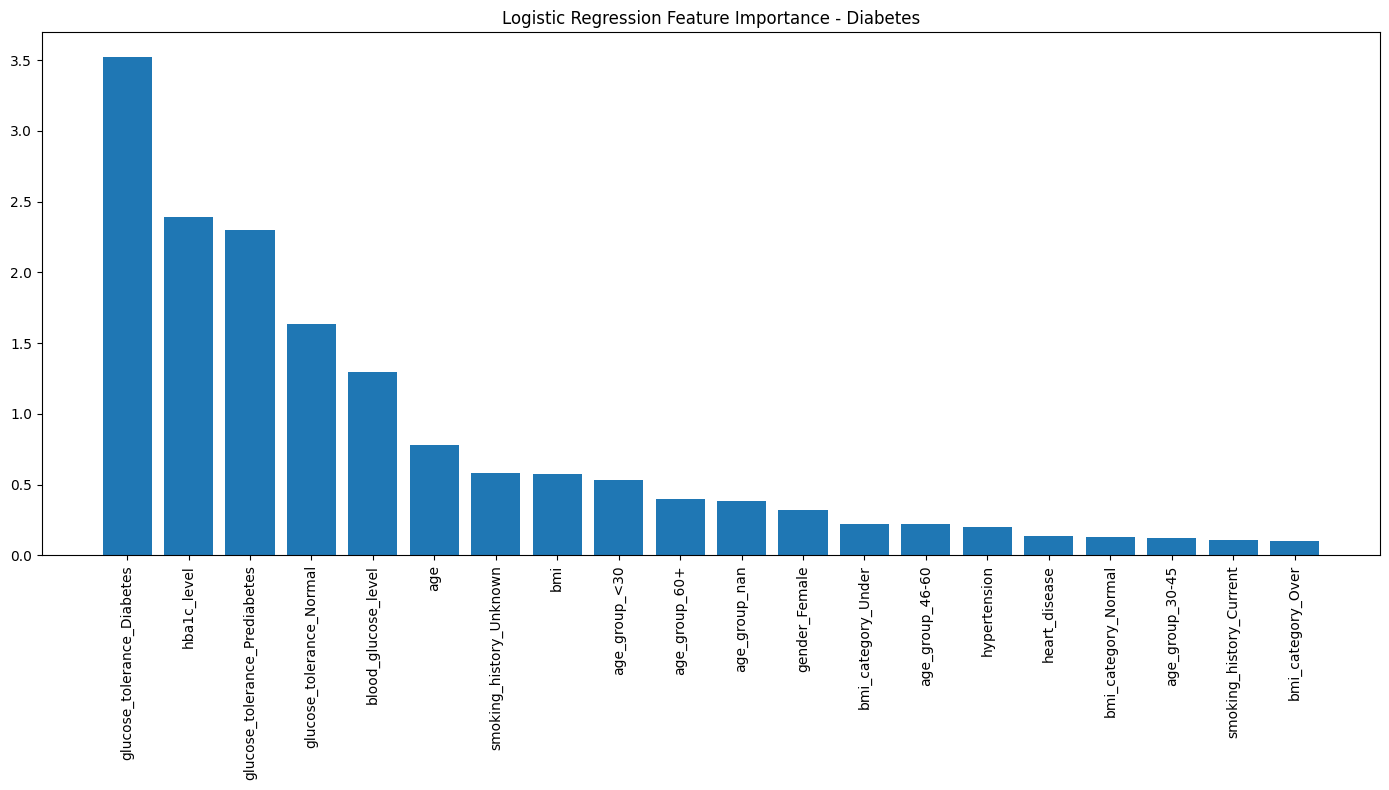


Analyzing Random Forest Feature Importance for Diabetes...


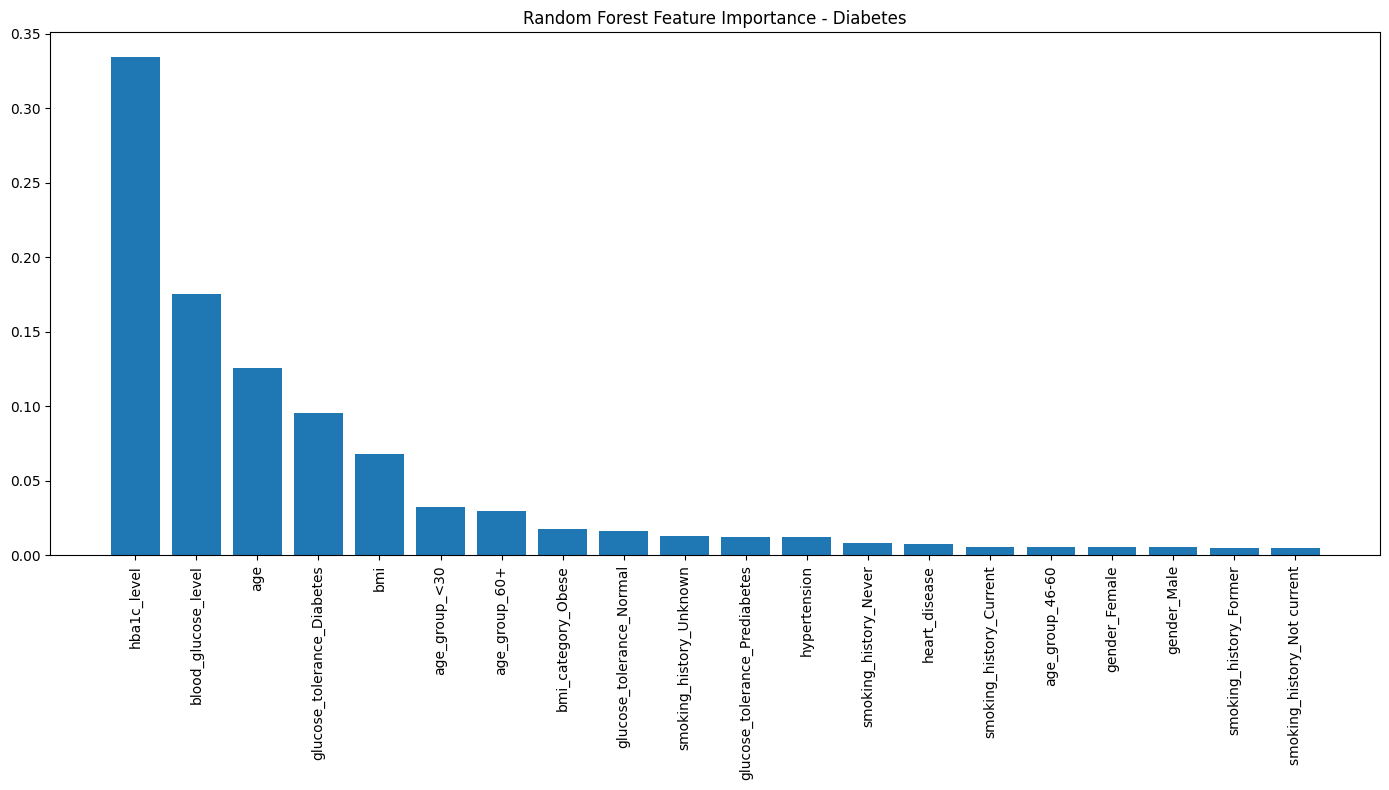


Analyzing XGBoost Feature Importance for Diabetes...


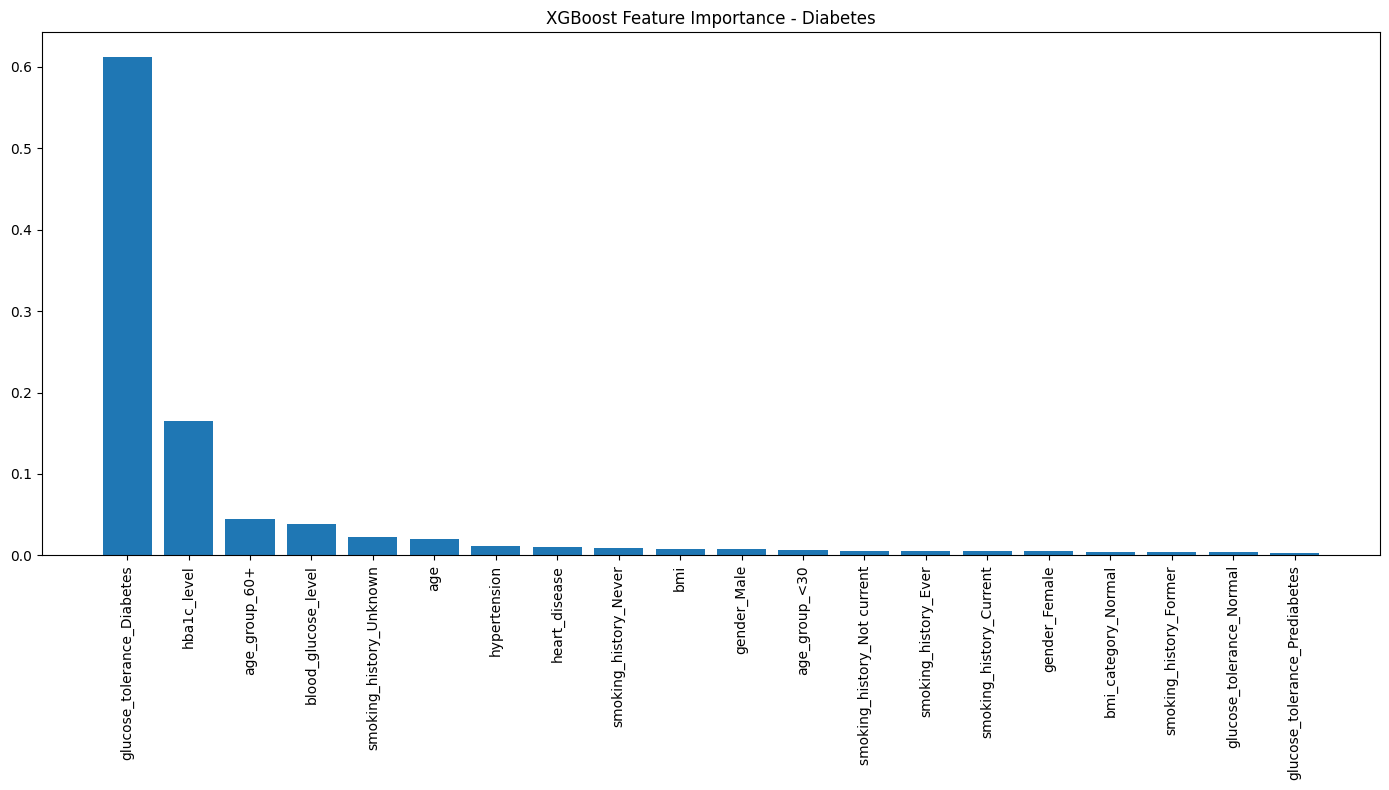


Calculating SHAP values for Diabetes...


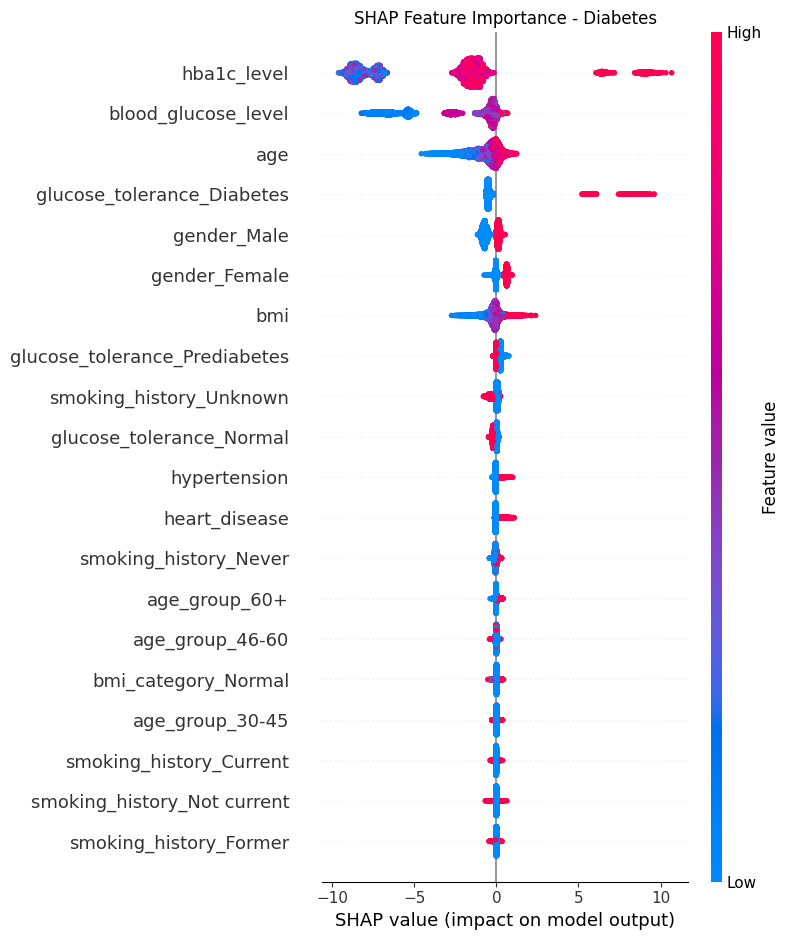

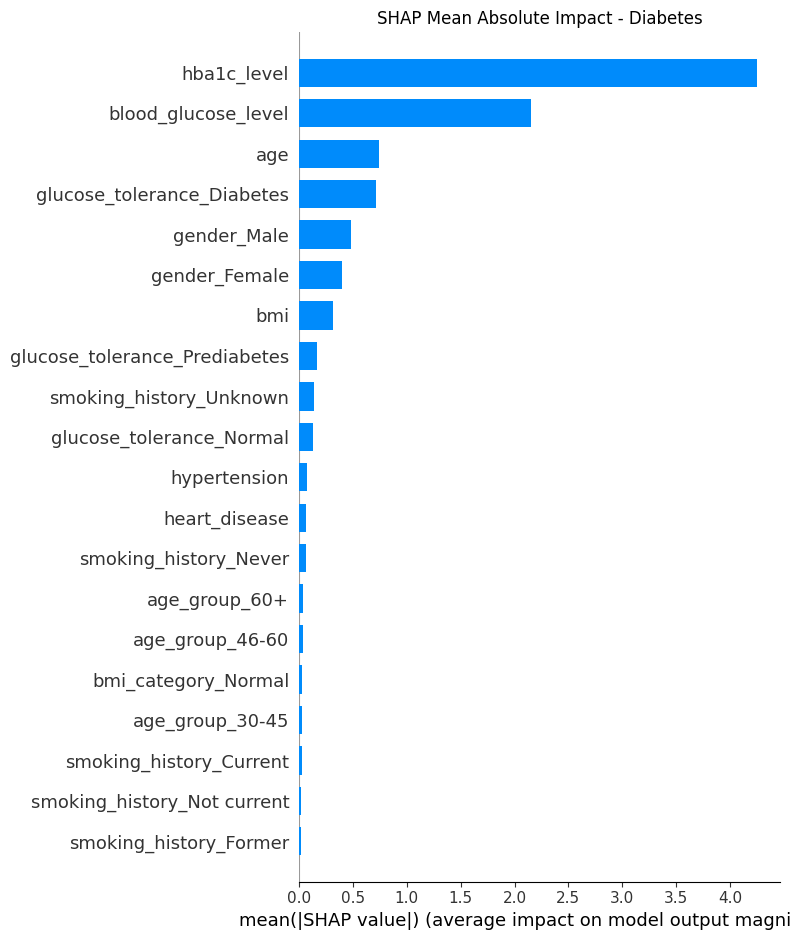

In [9]:
# Main execution
# 1. DIABETES FEATURE IMPORTANCE ANALYSIS
print("\n" + "="*50)
print("DIABETES DATASET FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Define diabetes dataset columns
diabetes_cat_cols = ['gender', 'smoking_history', 'age_group', 'bmi_category', 'glucose_tolerance']
diabetes_num_cols = [col for col in diabetes_df.columns if col not in diabetes_cat_cols + ['diabetes']]

# Prepare data for diabetes analysis
diabetes_data = prepare_data(
    diabetes_df, 'diabetes', 
    categorical_cols=diabetes_cat_cols, 
    numerical_cols=diabetes_num_cols
)

(X_train_diabetes, X_test_diabetes, X_train_proc_diabetes, X_test_proc_diabetes,
 X_train_smote_diabetes, y_train_smote_diabetes, 
 y_train_diabetes, y_test_diabetes, diabetes_features, _) = diabetes_data

# Analyze feature importance for diabetes
diabetes_results, diabetes_sorted_imp, diabetes_shap = analyze_feature_importance(
    X_train_smote_diabetes, y_train_smote_diabetes, 
    X_test_proc_diabetes, y_test_diabetes, 
    diabetes_features, "Diabetes"
)